In this build, we are building a xgboost model. 

The imputation methods are:
- Categorical: fill in with "NA"
- Numeric: fill in with -999

In [1]:
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
import xgboost as xgb
import pprint as pp
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import bnp_helper
import common_helper
import random
import os
import datetime
from sklearn.externals import joblib
from matplotlib.pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 16, 4
pd.set_option('display.max_columns', 500)

/Users/binlin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
################### Combine the training set and test set to fix the unmatched categories ############
train_df_raw = pd.read_csv("../data/train.csv")
test_df_raw = pd.read_csv("../data/test.csv")

df_raw_combined = pd.concat([train_df_raw, test_df_raw], axis = 0)

########### Clean and Impute (Combined) #############
df_combinded = bnp_helper.clean(df_raw_combined, drop_collinearity = True, inplace = True)
df_combinded = bnp_helper.impute_cate_with_na_numeric_with_outlier(df_combinded)

################ Convert text to number (Combined) ################
df_combinded = common_helper.dummify(df_combinded, bnp_helper.get_categorical_variables(df_combinded))
print df_combinded.shape
df_combinded.head()

(228714, 482)


,ID,target,v1,v10,v101,v102,v103,v108,v109,v114,v117,v119,v120,v122,v123,v124,v126,v127,v13,v130,v131,v14,v16,v18,v19,v2,v20,v21,v23,v27,v28,v35,v36,v37,v39,v4,v42,v43,v44,v45,v49,v50,v51,v53,v57,v58,v59,v6,v60,v61,v64,v69,v7,v70,v73,v77,v78,v80,v81,v82,v83,v84,v85,v86,v87,v88,v9,v90,v93,v94,v95,v96,v97,v98,v99,v107_B,v107_C,v107_D,v107_E,v107_F,v107_G,v107_NA,v110_B,v110_C,v112_B,v112_C,v112_D,v112_E,v112_F,v112_G,v112_H,v112_I,v112_J,v112_K,v112_L,v112_M,v112_N,v112_NA,v112_O,v112_P,v112_Q,v112_R,v112_S,v112_T,v112_U,v112_V,v113_AA,v113_AB,v113_AC,v113_AD,v113_AE,v113_AF,v113_AG,v113_AH,v113_AI,v113_AJ,v113_AK,v113_B,v113_C,v113_D,v113_E,v113_F,v113_G,v113_H,v113_I,v113_J,v113_K,v113_L,v113_M,v113_N,v113_NA,v113_O,v113_P,v113_Q,v113_R,v113_S,v113_T,v113_U,v113_V,v113_W,v113_X,v113_Y,v113_Z,v125_AA,v125_AB,v125_AC,v125_AD,v125_AE,v125_AF,v125_AG,v125_AH,v125_AI,v125_AJ,v125_AK,v125_AL,v125_AM,v125_AN,v125_AO,v125_AP,v125_AQ,v125_AR,v125_AS,v125_AT,v125_AU,v125_AV,v125_AW,v125_AX,v125_AY,v125_AZ,v125_B,v125_BA,v125_BB,v125_BC,v125_BD,v125_BE,v125_BF,v125_BG,v125_BH,v125_BI,v125_BJ,v125_BK,v125_BL,v125_BM,v125_BN,v125_BO,v125_BP,v125_BQ,v125_BR,v125_BS,v125_BT,v125_BU,v125_BV,v125_BW,v125_BX,v125_BY,v125_BZ,v125_C,v125_CA,v125_CB,v125_CC,v125_CD,v125_CE,v125_CF,v125_CG,v125_CH,v125_CI,v125_CJ,v125_CK,v125_CL,v125_D,v125_E,v125_F,v125_G,v125_H,v125_I,v125_J,v125_K,v125_L,v125_M,v125_N,v125_NA,v125_O,v125_P,v125_Q,v125_R,v125_S,v125_T,v125_U,v125_V,v125_W,v125_X,v125_Y,v125_Z,v129_1,v129_11,v129_2,v129_3,v129_4,v129_5,v129_6,v129_7,v129_8,v24_B,v24_C,v24_D,v24_E,v3_B,v3_C,v3_NA,v30_B,v30_C,v30_D,v30_E,v30_F,v30_G,v30_NA,v31_B,v31_C,v31_NA,v38_1,v38_10,v38_12,v38_2,v38_3,v38_4,v38_5,v38_6,v38_7,v38_8,v38_9,v47_B,v47_C,v47_D,v47_E,v47_F,v47_G,v47_H,v47_I,v47_J,v52_B,v52_C,v52_D,v52_E,v52_F,v52_G,v52_H,v52_I,v52_J,v52_K,v52_L,v52_NA,v56_AA,v56_AB,v56_AC,v56_AD,v56_AE,v56_AF,v56_AG,v56_AH,v56_AI,v56_AJ,v56_AK,v56_AL,v56_AM,v56_AN,v56_AO,v56_AP,v56_AQ,v56_AR,v56_AS,v56_AT,v56_AU,v56_AV,v56_AW,v56_AX,v56_AY,v56_AZ,v56_B,v56_BA,v56_BB,v56_BC,v56_BD,v56_BE,v56_BF,v56_BG,v56_BH,v56_BI,v56_BJ,v56_BK,v56_BL,v56_BM,v56_BN,v56_BO,v56_BP,v56_BQ,v56_BR,v56_BS,v56_BT,v56_BU,v56_BV,v56_BW,v56_BX,v56_BY,v56_BZ,v56_C,v56_CA,v56_CB,v56_CC,v56_CD,v56_CE,v56_CF,v56_CG,v56_CH,v56_CI,v56_CJ,v56_CK,v56_CL,v56_CM,v56_CN,v56_CO,v56_CP,v56_CQ,v56_CR,v56_CS,v56_CT,v56_CU,v56_CV,v56_CW,v56_CX,v56_CY,v56_CZ,v56_D,v56_DA,v56_DB,v56_DC,v56_DD,v56_DE,v56_DF,v56_DG,v56_DH,v56_DI,v56_DJ,v56_DK,v56_DL,v56_DM,v56_DN,v56_DO,v56_DP,v56_DQ,v56_DR,v56_DS,v56_DT,v56_DU,v56_DV,v56_DW,v56_DX,v56_DY,v56_DZ,v56_E,v56_F,v56_G,v56_H,v56_I,v56_J,v56_K,v56_L,v56_M,v56_N,v56_NA,v56_O,v56_P,v56_Q,v56_R,v56_S,v56_T,v56_U,v56_V,v56_W,v56_X,v56_Y,v56_Z,v62_1,v62_2,v62_3,v62_4,v62_5,v62_6,v62_7,v66_B,v66_C,v71_B,v71_C,v71_D,v71_E,v71_F,v71_G,v71_H,v71_I,v71_J,v71_K,v71_L,v72_1,v72_10,v72_11,v72_12,v72_2,v72_3,v72_4,v72_5,v72_6,v72_7,v72_8,v72_9,v74_B,v74_C,v75_B,v75_C,v75_D,v79_B,v79_C,v79_D,v79_E,v79_F,v79_G,v79_H,v79_I,v79_J,v79_K,v79_L,v79_M,v79_N,v79_O,v79_P,v79_Q,v79_R,v91_B,v91_C,v91_D,v91_E,v91_F,v91_G,v91_NA
0,3,1,1.335739,0.503281,8.389237,2.757375,4.374296,2.382692,3.930922,15.634907,6.592012,-6.297423e-07,1.059603,8.000000,1.989780,0.035754,1.804126,3.113719,2.866830,0.636365,2.857144,11.636387,8.571429,0.106720,0.148883,8.727474,18.869283,7.730923,-1.716131e-08,3.393503,0.590122,8.375452,11.326592,0.454546,4.012088,3.921026,12.707581,2.015505,10.498338,9.848672,8.086643,0.899420,7.277792,16.747968,3.971118,0.529802,10.890984,2.599278,1.588448,15.858152,6.363189,17.142857,3.176895,11.784549,1.614988,7.292418,8.571429,3.000000,7.528326,8.861647,0.649820,1.299638,1.707317,0.866426,9.551836,3.321300,9.999999,0.905342,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [3]:
train_df = df_combinded[-df_raw_combined['target'].isnull()]
test_df = df_combinded[df_raw_combined['target'].isnull()]

train_df_sample = train_df.sample(40000, random_state = 0)
#train_df_sample = train_df
target_train = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 96


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=97, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8)

Model Report
Accuracy : 0.7979
AUC Score (Train): 0.806581
Log Loss (Train): 0.434604
model run time: 0:02:56.951067


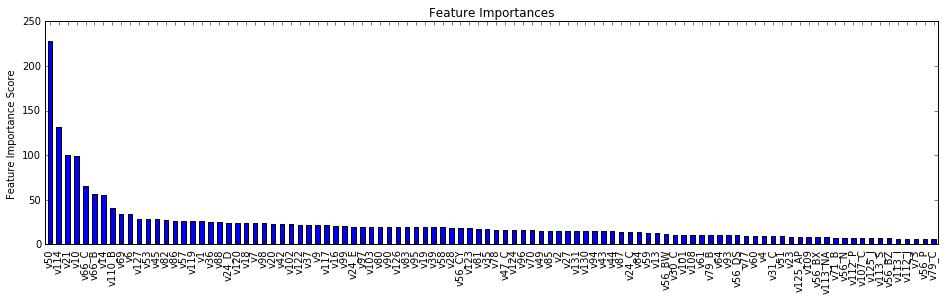

In [13]:
######### Set initial values for the model ######
xgb_model = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=8,
    scale_pos_weight=1,
    seed=27)

start = datetime.datetime.now()
bnp_helper.xgboost_model_fit(xgb_model, X_train, target_train, ['logloss'])
end = datetime.datetime.now()

print "model run time: {}".format(end - start)

bnp_helper.feature_importance_plot(xgb_model.booster().get_fscore(), 100)

In [14]:
################# Tune max_depth and min_child_weight ##############
param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), \
    param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:19:26.508888


([mean: -0.47317, std: 0.00234, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.47302, std: 0.00238, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.47291, std: 0.00232, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.47140, std: 0.00200, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.47129, std: 0.00172, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.47107, std: 0.00189, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.47192, std: 0.00183, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.47236, std: 0.00217, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.47185, std: 0.00221, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.47497, std: 0.00237, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.47508, std: 0.00252, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.47525, std: 0.00191, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

In [5]:
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test2, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:12:08.700692


([mean: -0.47174, std: 0.00235, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: -0.47148, std: 0.00158, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.47171, std: 0.00182, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.47136, std: 0.00220, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -0.47107, std: 0.00189, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.47102, std: 0.00249, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: -0.47145, std: 0.00194, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: -0.47112, std: 0.00136, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.47068, std: 0.00240, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 6, 'min_child_weight': 6},
 -0.47067585984144866)

In [6]:
param_test3 = {
    'max_depth':[6,7],
    'min_child_weight':[6,7,8]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test3, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:10:26.276239


([mean: -0.47068, std: 0.00240, params: {'max_depth': 6, 'min_child_weight': 6},
  mean: -0.47063, std: 0.00167, params: {'max_depth': 6, 'min_child_weight': 7},
  mean: -0.47095, std: 0.00222, params: {'max_depth': 6, 'min_child_weight': 8},
  mean: -0.47231, std: 0.00180, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -0.47122, std: 0.00280, params: {'max_depth': 7, 'min_child_weight': 7},
  mean: -0.47148, std: 0.00216, params: {'max_depth': 7, 'min_child_weight': 8}],
 {'max_depth': 6, 'min_child_weight': 7},
 -0.47062606235677518)

In [7]:
################### tune gamma ################
param_test4 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[i/10.0 for i in range(0,10,2)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test4, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:09:21.332892


([mean: -0.47038, std: 0.00191, params: {'max_depth': 6, 'gamma': 0.0, 'min_child_weight': 7},
  mean: -0.47070, std: 0.00215, params: {'max_depth': 6, 'gamma': 0.2, 'min_child_weight': 7},
  mean: -0.47022, std: 0.00176, params: {'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47093, std: 0.00257, params: {'max_depth': 6, 'gamma': 0.6, 'min_child_weight': 7},
  mean: -0.47040, std: 0.00203, params: {'max_depth': 6, 'gamma': 0.8, 'min_child_weight': 7}],
 {'gamma': 0.4, 'max_depth': 6, 'min_child_weight': 7},
 -0.47022238249587966)

In [8]:
param_test5 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[0.3, 0.4, 0.5]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test5, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:05:24.095599


([mean: -0.47063, std: 0.00167, params: {'max_depth': 6, 'gamma': 0.3, 'min_child_weight': 7},
  mean: -0.47022, std: 0.00176, params: {'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47067, std: 0.00197, params: {'max_depth': 6, 'gamma': 0.5, 'min_child_weight': 7}],
 {'gamma': 0.4, 'max_depth': 6, 'min_child_weight': 7},
 -0.47022238249587966)

In [9]:
################ Tune subsample and colsample_bytree ###############
param_test6 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[0.4],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test6, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:22:18.521394


([mean: -0.47321, std: 0.00247, params: {'subsample': 0.6, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47239, std: 0.00237, params: {'subsample': 0.7, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47107, std: 0.00212, params: {'subsample': 0.8, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47079, std: 0.00144, params: {'subsample': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47223, std: 0.00235, params: {'subsample': 0.6, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47183, std: 0.00188, params: {'subsample': 0.7, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47067, std: 0.00198, params: {'subsample': 0.8, 'colsample_bytree': 0.7, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47069, std: 0.00191, pa

In [10]:
param_test7 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[0.4],
    'subsample':[0.75, 0.8, 0.85],
    'colsample_bytree':[0.75, 0.8, 0.85]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test7, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:14:10.052679


([mean: -0.47111, std: 0.00123, params: {'subsample': 0.75, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47116, std: 0.00198, params: {'subsample': 0.8, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47064, std: 0.00187, params: {'subsample': 0.85, 'colsample_bytree': 0.75, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47114, std: 0.00168, params: {'subsample': 0.75, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47022, std: 0.00176, params: {'subsample': 0.8, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47068, std: 0.00161, params: {'subsample': 0.85, 'colsample_bytree': 0.8, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47133, std: 0.00131, params: {'subsample': 0.75, 'colsample_bytree': 0.85, 'max_depth': 6, 'gamma': 0.4, 'min_child_weight': 7},
  mean: -0.47050, std: 0.

In [11]:
################ Tune reg_alpha #############
param_test8 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[0.4],
    'subsample':[0.85],
    'colsample_bytree':[0.85],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test8, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:09:05.201933


([mean: -0.47013, std: 0.00177, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47014, std: 0.00175, params: {'reg_alpha': 0.01, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47035, std: 0.00207, params: {'reg_alpha': 0.1, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47052, std: 0.00195, params: {'reg_alpha': 1, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47798, std: 0.00292, params: {'reg_alpha': 100, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4}],
 {'colsample_bytree': 0.85,
  'gamma': 0.4,
  'max_depth': 6,
  'min_child_weight': 7,
  'reg_alpha': 1e-05,
  'subsample': 0.85},
 -0.47012943456906431)

In [12]:
param_test9 = {
    'max_depth':[6],
    'min_child_weight':[7], 
    'gamma':[0.4],
    'subsample':[0.85],
    'colsample_bytree':[0.85],
    'reg_alpha':[1e-6, 1e-5, 1e-4]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=5, \
    min_child_weight=3, gamma=0.3, subsample=0.8, colsample_bytree=0.8, \
    objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \
    param_grid = param_test9, scoring='log_loss',n_jobs=4,iid=False, cv=5)

start = datetime.datetime.now()
gsearch1.fit(X_train, target_train)
end = datetime.datetime.now()
print "model training time: {}".format(end - start)

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

model training time: 0:05:43.448175


([mean: -0.47013, std: 0.00177, params: {'reg_alpha': 1e-06, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47013, std: 0.00177, params: {'reg_alpha': 1e-05, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4},
  mean: -0.47001, std: 0.00174, params: {'reg_alpha': 0.0001, 'colsample_bytree': 0.85, 'min_child_weight': 7, 'subsample': 0.85, 'max_depth': 6, 'gamma': 0.4}],
 {'colsample_bytree': 0.85,
  'gamma': 0.4,
  'max_depth': 6,
  'min_child_weight': 7,
  'reg_alpha': 0.0001,
  'subsample': 0.85},
 -0.47001335054718912)

In [13]:
#train_df_sample = train_df.sample(10000, random_state = 0)
train_df_sample = train_df
target_train = train_df_sample['target']
X_train = train_df_sample.drop(['ID', 'target'], axis = 1)

In [14]:
# Fit the model with best parameters and reduced learing rate
xgb_model = XGBClassifier(
    learning_rate =0.05,    # learning rate
    n_estimators=1000,
    max_depth=6,           # depth of tree, typical value 3-10, tunned
    min_child_weight=7,    # min number of observations in a node, tunned
    gamma=0.4,             # min loss reduction to make a split, tunned
    subsample=0.85,         # number of rows, tunned
    colsample_bytree=0.85,  # number of columns, tunned
    reg_alpha=0.0001,       # L1 regularization term on weight (analogous to Lasso regression)
    objective= 'binary:logistic',
    nthread=6,
    scale_pos_weight=1,    # > 0 value in case of high class imbalance
    seed=27)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 611


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.85,
       gamma=0.4, learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=7, missing=None, n_estimators=612, nthread=6,
       objective='binary:logistic', reg_alpha=0.0001, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.85)

Model Report
Accuracy : 0.812
AUC Score (Train): 0.842798
Log Loss (Train): 0.408851
model training time: 0:52:11.775626


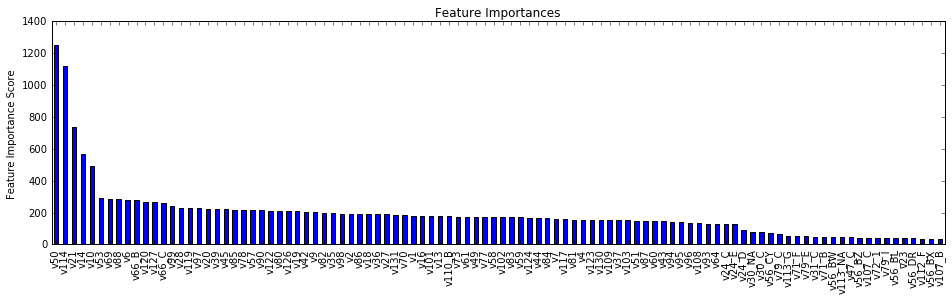

In [16]:
###### Fit the best model with training data #######
start = datetime.datetime.now()
bnp_helper.xgboost_model_fit(xgb_model, X_train, target_train, ["logloss"])
end = datetime.datetime.now()

print "model training time: {}".format(end - start)

bnp_helper.feature_importance_plot(xgb_model.booster().get_fscore(), 100)


In [17]:
joblib.dump(xgb_model, 'xgb_model_2.pkl')

['xgb_model_2.pkl', 'xgb_model_2.pkl_01.npy']

In [18]:
################# Predict the test set and save result to file ############
#test_df_sample = test_df.sample(1000, random_state = 0)
test_df_sample = test_df

X_test = test_df_sample.drop(['ID', 'target'], axis = 1)

#Predict test set:
predprob_test = xgb_model.predict_proba(X_test)
        
# Save results
ids = test_df_sample['ID']
predprob_one_test = [p[1] for p in predprob_test]
bnp_helper.save_result(ids, predprob_one_test, "xgboost_model_2_result.csv")

print('Done.')

Done.
